In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_df_summary(df, strategy="best"):
    assert strategy in ["best", "enh", "sup"], f"strategy must be 'best' or 'mean', but got {strategy}" # bestの場合各行ごとに、enh or supのうち「改善している方」（値が小さい方）を選ぶ
    if strategy == "best":
        df["best_gap_correct"] = df[["mean_diff_conf_correct_mod_enhance", "mean_diff_conf_correct_mod_suppress"]].min(axis=1)
        df["best_gap_incorrect"] = df[["mean_diff_conf_incorrect_mod_enhance", "mean_diff_conf_incorrect_mod_suppress"]].min(axis=1)
        df["best_loss_correct"] = df[["mean_loss_correct_mod_enhance", "mean_loss_correct_mod_suppress"]].min(axis=1)
        df["best_loss_incorrect"] = df[["mean_loss_incorrect_mod_enhance", "mean_loss_incorrect_mod_suppress"]].min(axis=1)
    elif strategy == "enh":
        df["best_gap_correct"] = df["mean_diff_conf_correct_mod_enhance"]
        df["best_gap_incorrect"] = df["mean_diff_conf_incorrect_mod_enhance"]
        df["best_loss_correct"] = df["mean_loss_correct_mod_enhance"]
        df["best_loss_incorrect"] = df["mean_loss_incorrect_mod_enhance"]
    elif strategy == "sup":
        df["best_gap_correct"] = df["mean_diff_conf_correct_mod_suppress"]
        df["best_gap_incorrect"] = df["mean_diff_conf_incorrect_mod_suppress"]
        df["best_loss_correct"] = df["mean_loss_correct_mod_suppress"]
        df["best_loss_incorrect"] = df["mean_loss_incorrect_mod_suppress"]
    df["diff_gap_correct"] = df["best_gap_correct"] - df["mean_diff_conf_correct_baseline"]
    df["diff_loss_correct"] = df["best_loss_correct"] - df["mean_loss_correct_baseline"]
    df["diff_gap_incorrect"] = df["best_gap_incorrect"] - df["mean_diff_conf_incorrect_baseline"]
    df["diff_loss_incorrect"] = df["best_loss_incorrect"] - df["mean_loss_incorrect_baseline"]
    # 必要な列だけ抽出。今回は条件軸は tgt_rank, misclf_combined, method, n_ratio, w_num  
    # 指標としては4つの指標（correct/inaccurate, gap と loss）を使う
    df_summary = df[["tgt_rank", "misclf_combined", "method", "n_ratio", "w_num", 
                    "diff_gap_correct", "diff_loss_correct", "diff_gap_incorrect", "diff_loss_incorrect"]].copy()

    # tgt_rank は整数型に変更
    df_summary["tgt_rank"] = df_summary["tgt_rank"].astype(int)
    return df_summary

In [15]:
# CSV ファイルを読み込み（例："all_experiment_results.csv"）
df1 = pd.read_csv("exp-fl-4-4.csv")
df1 = df1[df1["method"] != "ours"]
df2 = pd.read_csv("exp-fl-6-2.csv")
# df1と df2 をたてに結合
df = pd.concat([df1, df2], axis=0)
print(df.shape)

(60, 30)


In [16]:
# misclf_type と fpfn を統合する関数
def combine_misclf(row):
    if pd.isna(row["fpfn"]) or row["fpfn"] in [None, ""]:
        return row["misclf_type"]
    else:
        return f"{row['misclf_type']}_{row['fpfn']}"

# 新しい列 misclf_combined を作成
df["misclf_combined"] = df.apply(combine_misclf, axis=1)

df_best = make_df_summary(df)
df_enh = make_df_summary(df, strategy="enh")
df_sup = make_df_summary(df, strategy="sup")

Best


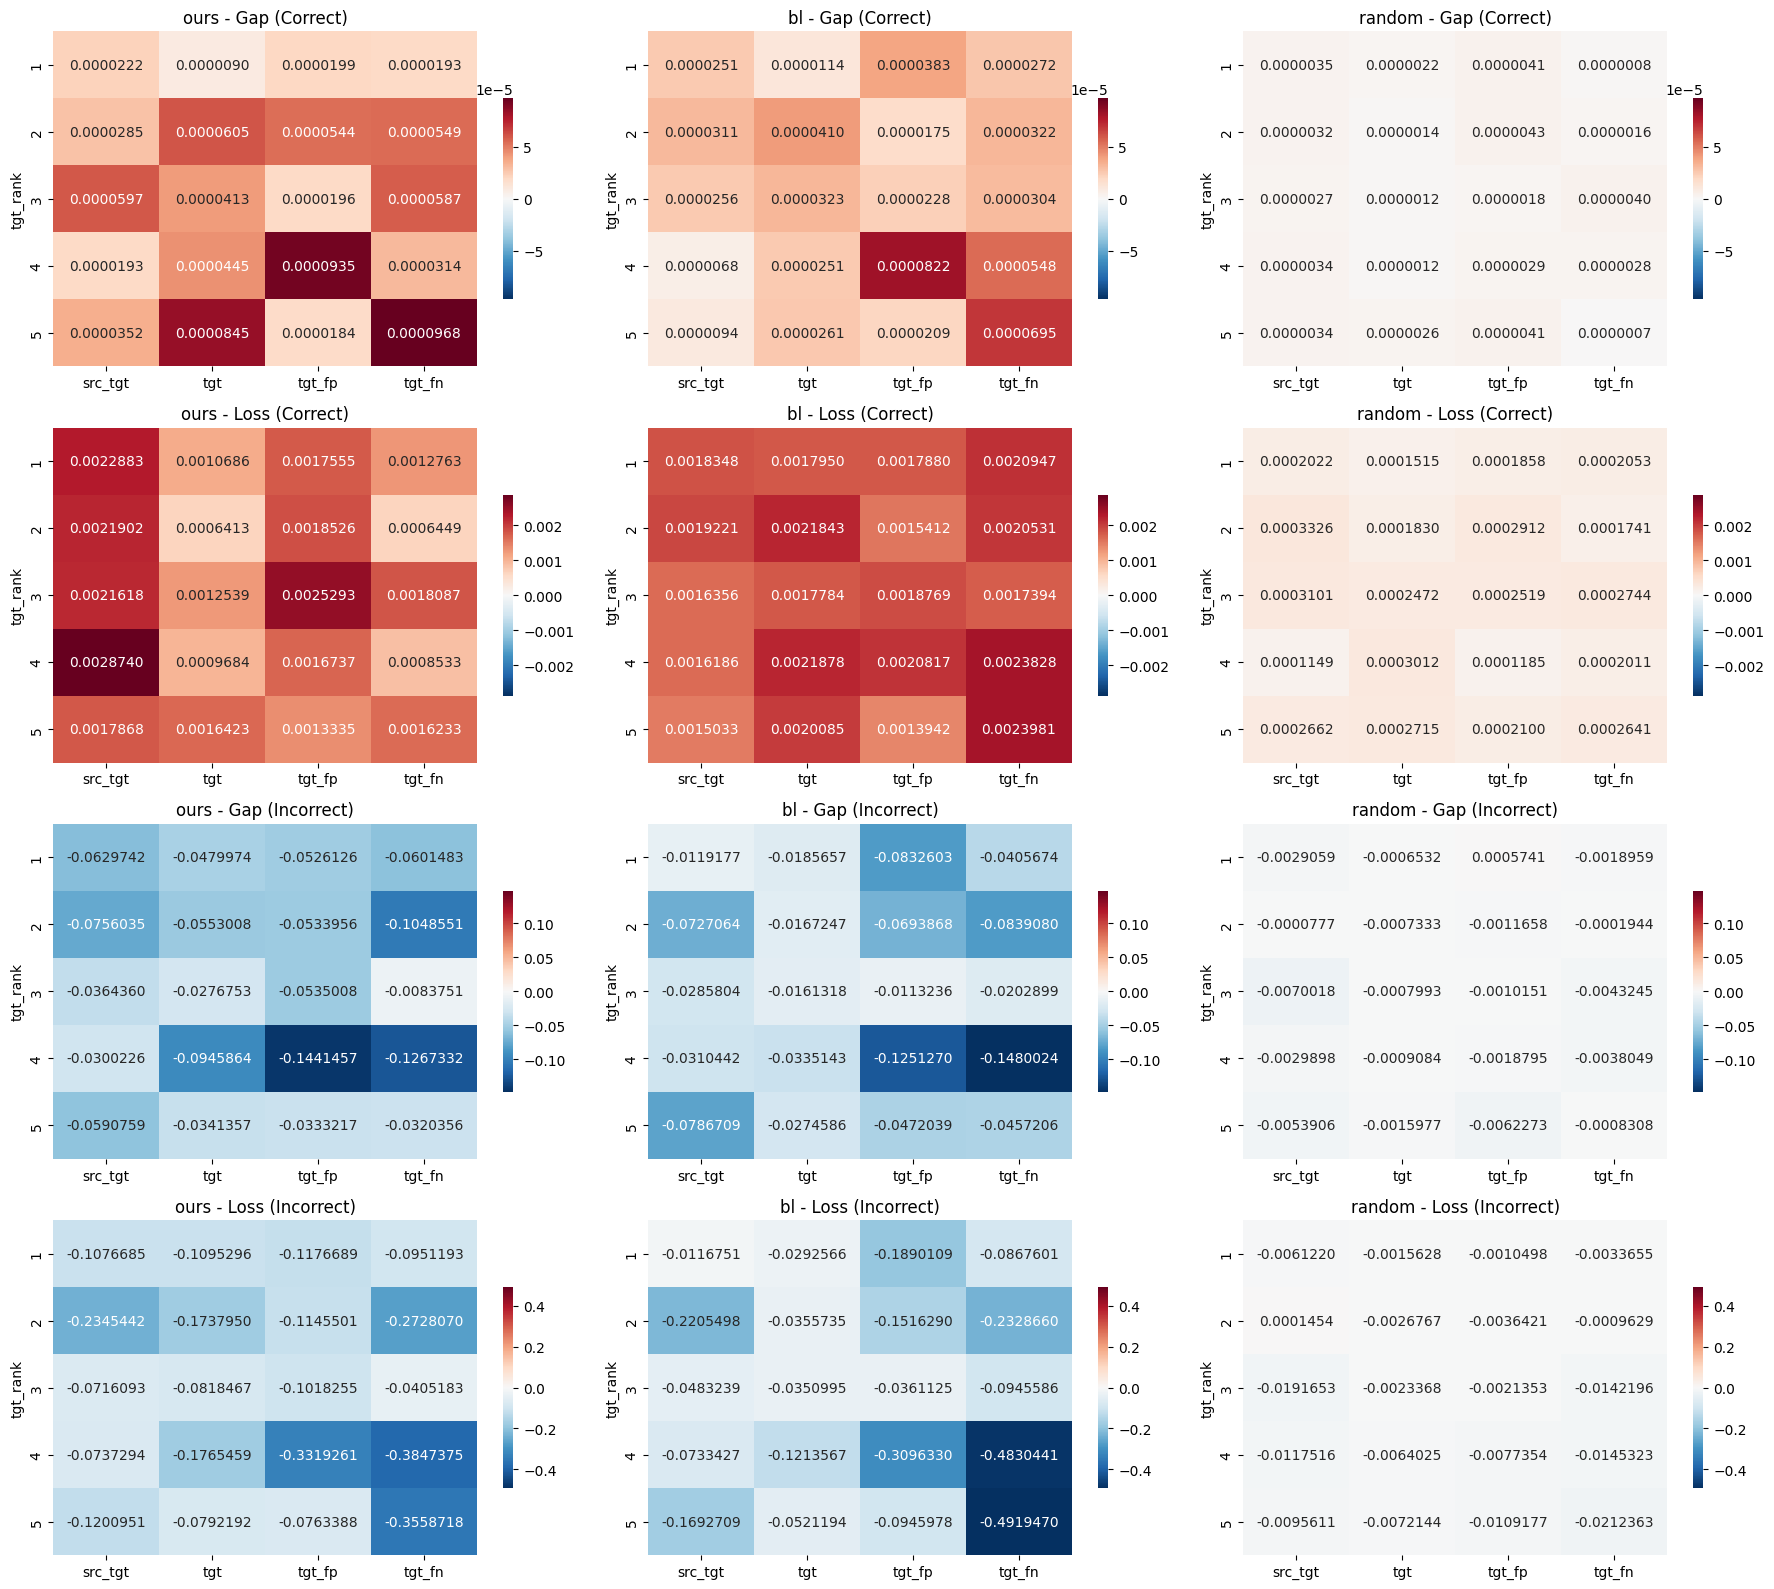

Enhance


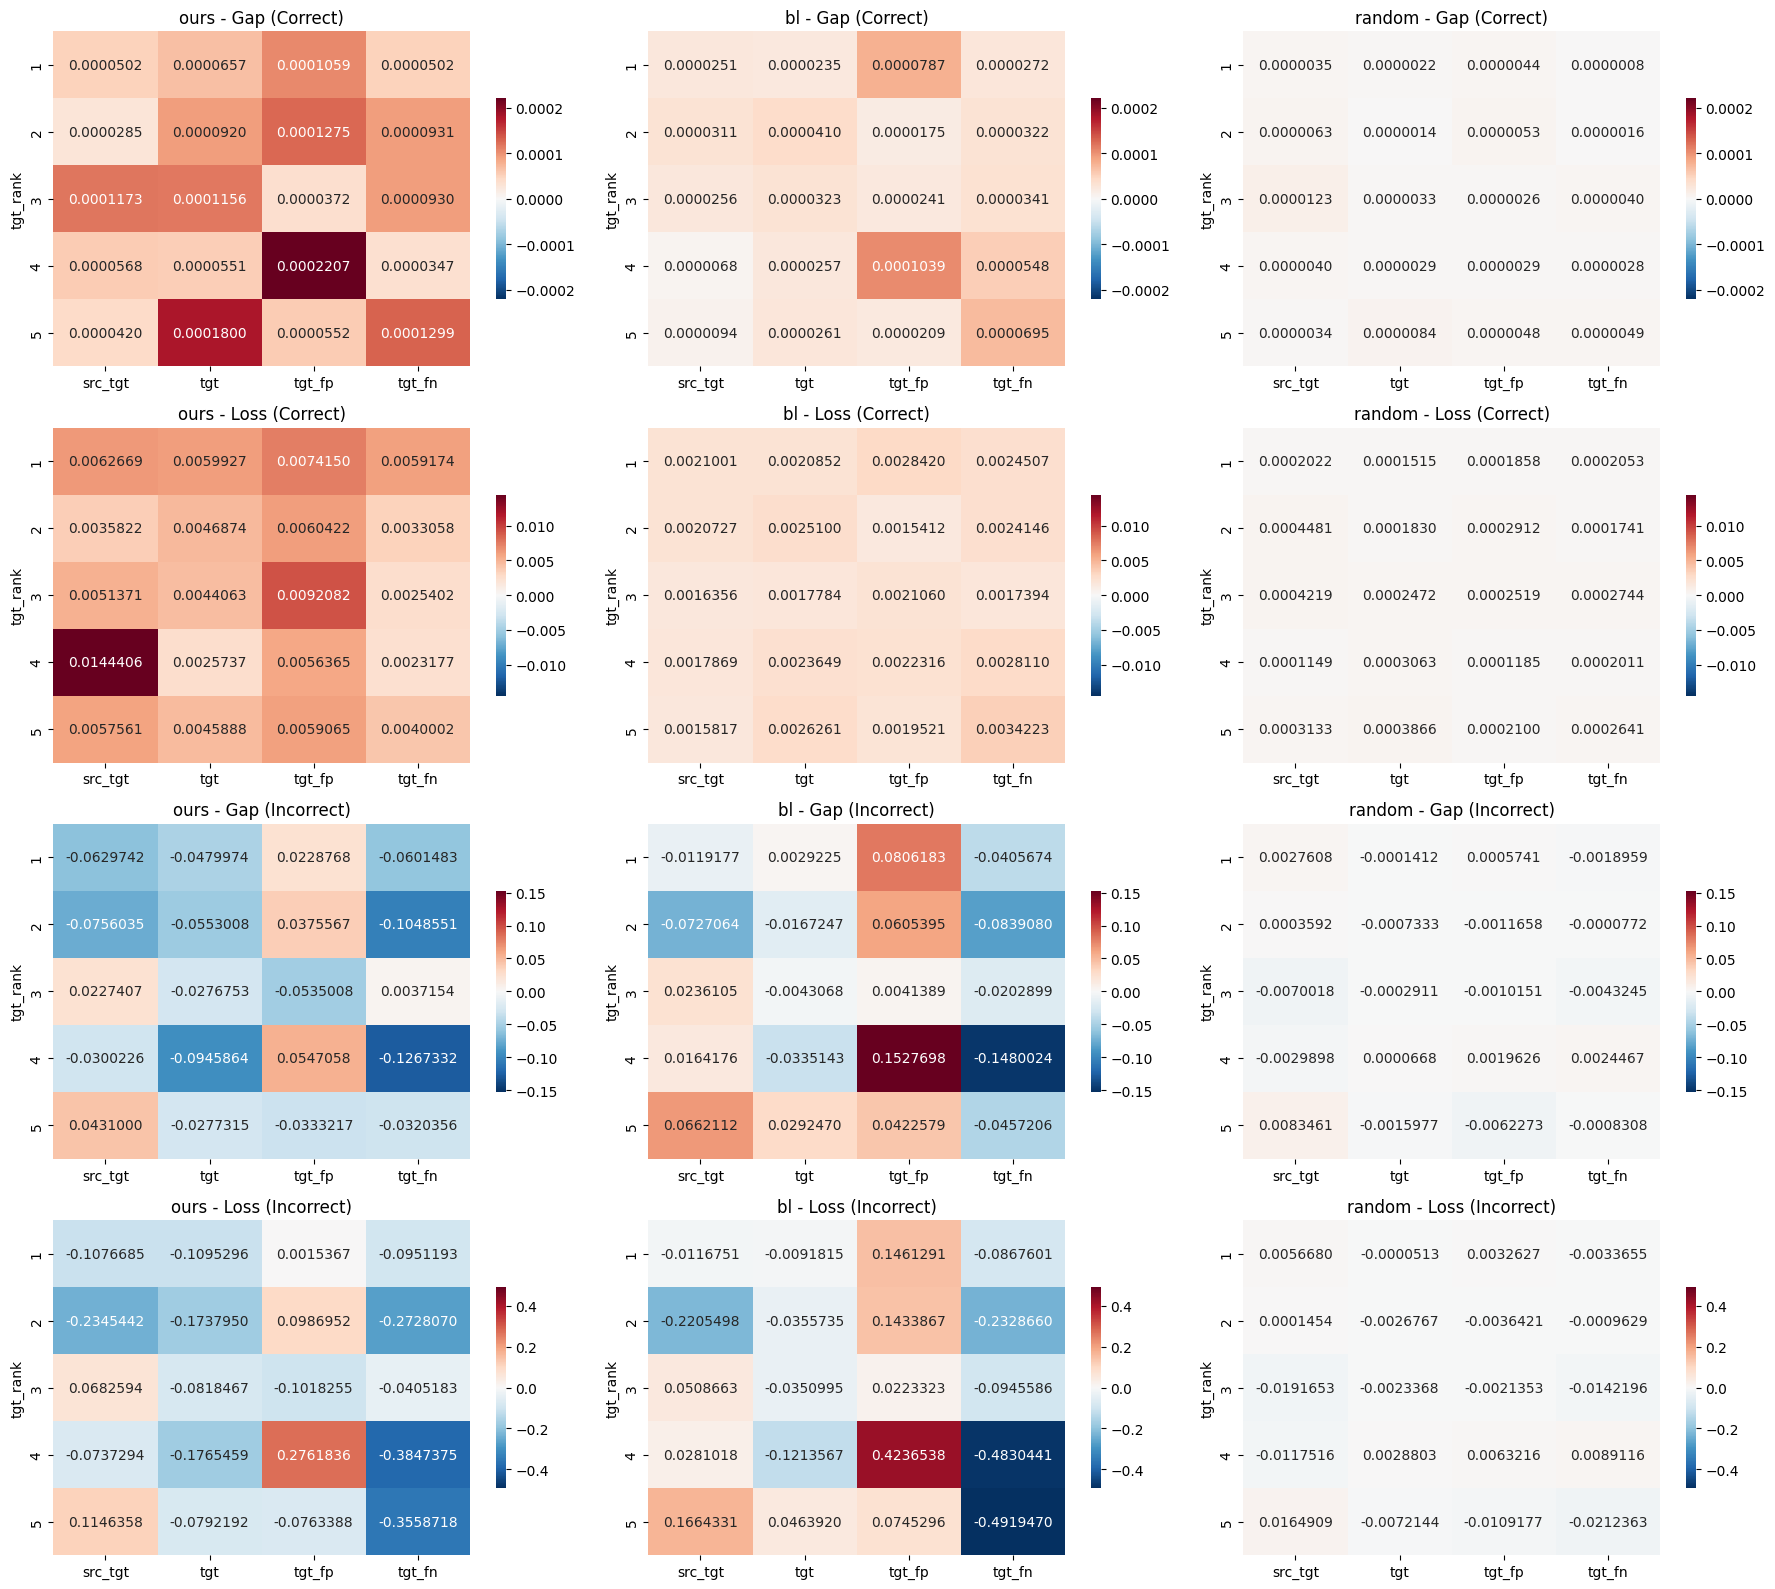

Suppress


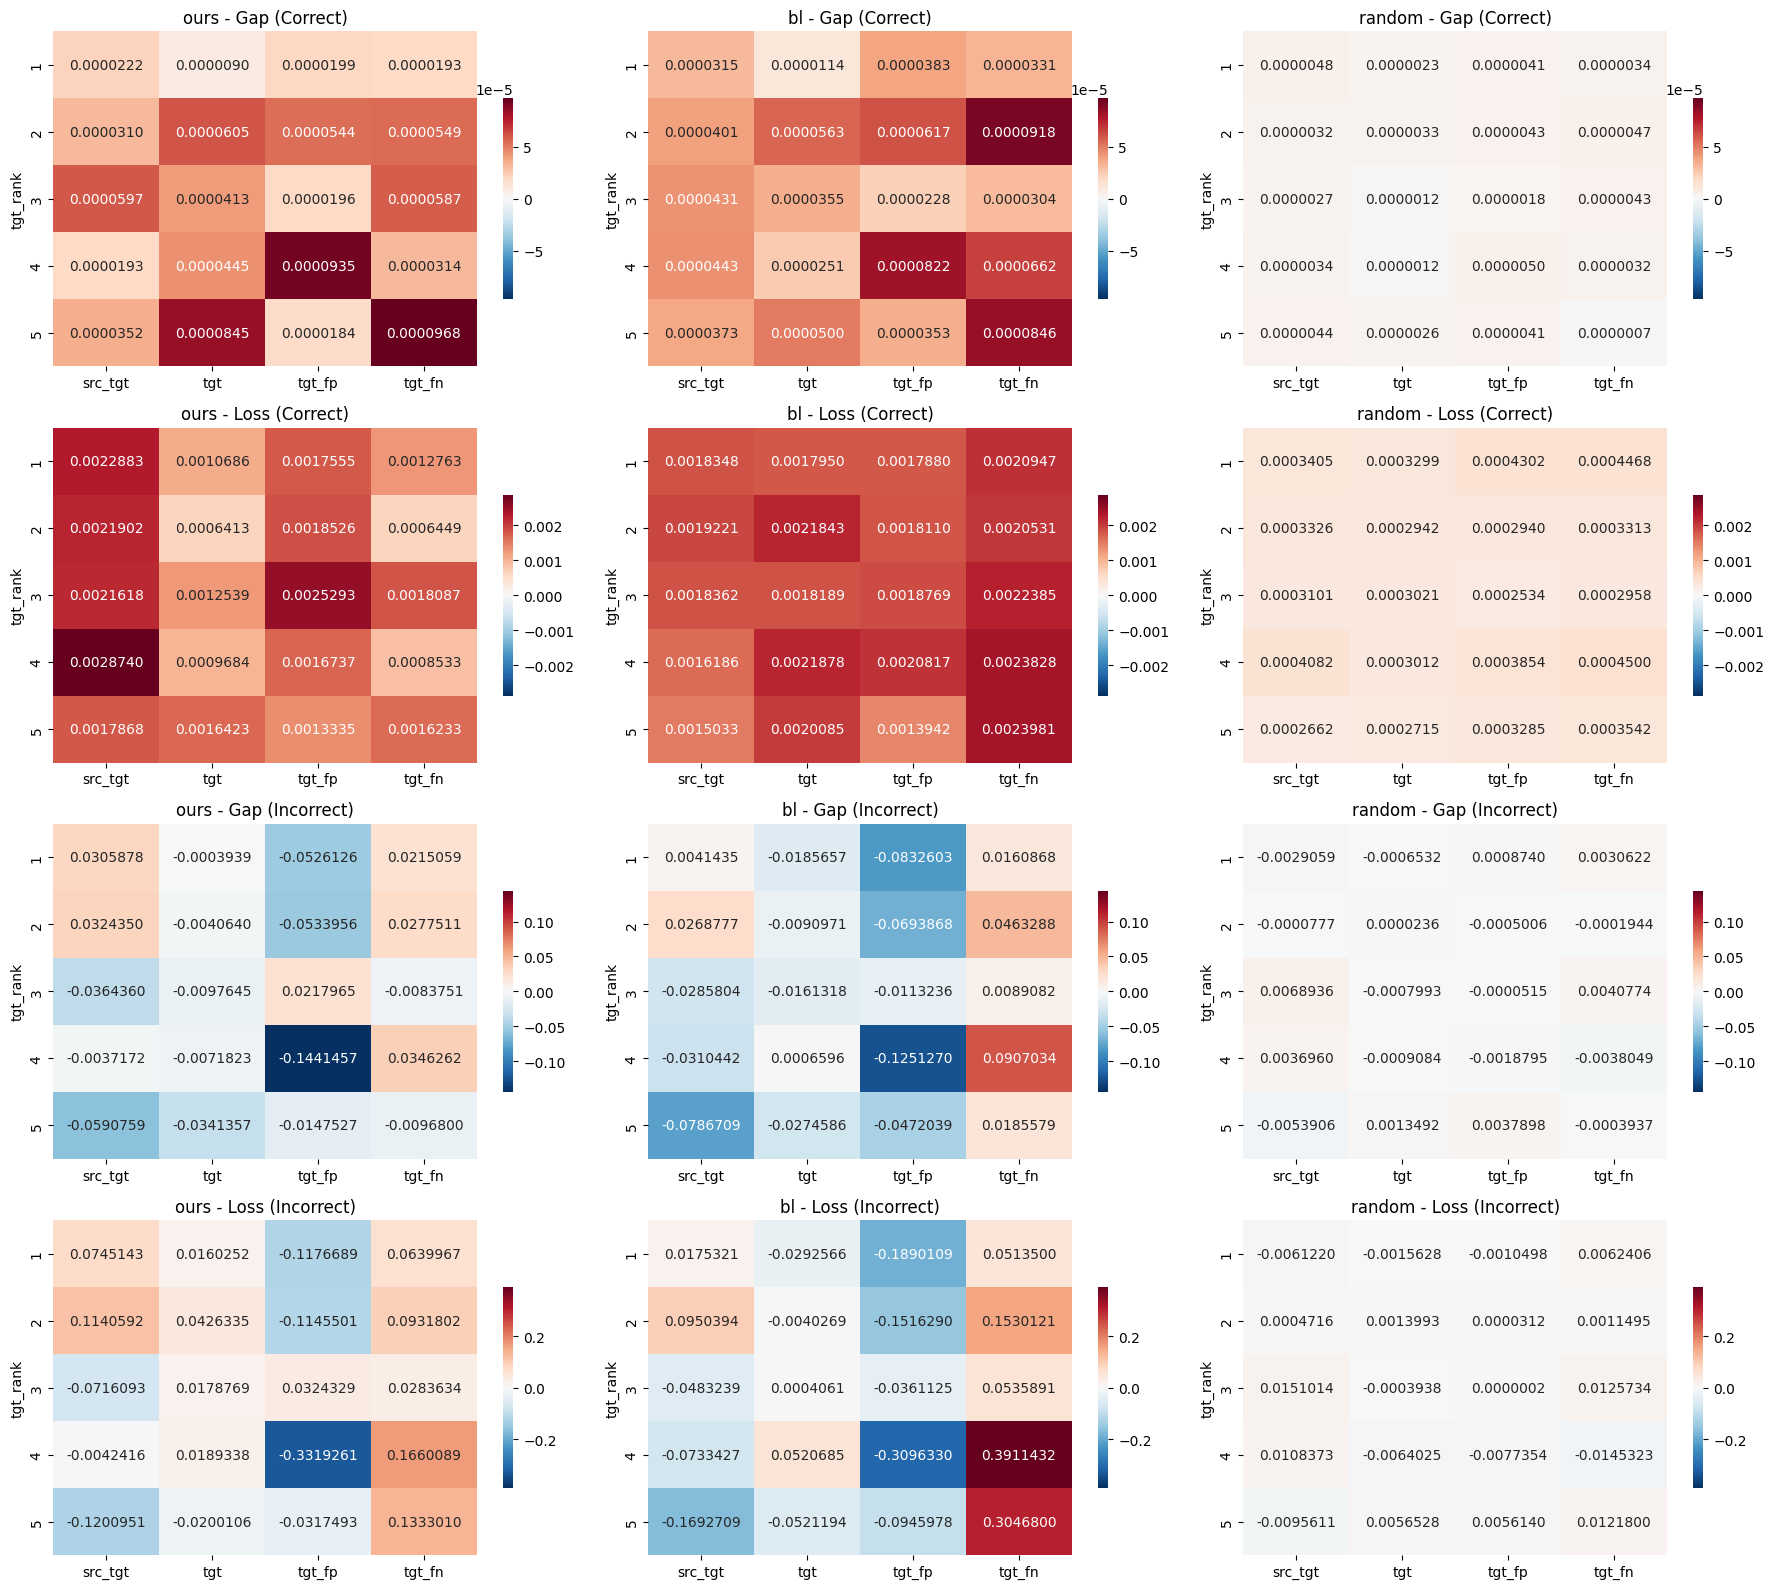

In [17]:
def show_heatmaps(df_summary):
    ordered_ranks = [1, 2, 3, 4, 5]
    ordered_misclf = ["src_tgt", "tgt", "tgt_fp", "tgt_fn"]
    methods = ["ours", "bl", "random"]
    metric_names = ["diff_gap_correct", "diff_loss_correct", "diff_gap_incorrect", "diff_loss_incorrect"]
    row_titles = ["Gap (Correct)", "Loss (Correct)", "Gap (Incorrect)", "Loss (Incorrect)"]

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    cmap = "RdBu_r"

    # 各行（=同じmetric）ごとにvmin, vmaxをそろえる
    for row_index, metric in enumerate(metric_names):
        # すべてのmethodsに対する最大・最小値を抽出
        row_vals = []
        for method in methods:
            df_method = df_summary[df_summary["method"] == method]
            values = df_method[metric].values
            row_vals.extend(values[~np.isnan(values)])  # 欠損値除外
        vmin = min(row_vals)
        vmax = max(row_vals)

        # ここで中心を0に近づける場合（任意）
        max_abs = max(abs(vmin), abs(vmax))
        vmin, vmax = -max_abs, max_abs

        for col_index, method in enumerate(methods):
            ax = axes[row_index, col_index]
            df_method = df_summary[df_summary["method"] == method]
            pivot_table = df_method.pivot_table(index="tgt_rank", columns="misclf_combined", values=metric)
            pivot_table = pivot_table.reindex(index=ordered_ranks, columns=ordered_misclf)

            sns.heatmap(pivot_table, ax=ax, annot=True, fmt=".7f", cmap=cmap,
                        center=0, vmin=vmin, vmax=vmax, cbar_kws={"shrink": 0.6})

            ax.set_title(f"{method} - {row_titles[row_index]}")
            ax.set_xlabel("")
            ax.set_ylabel("tgt_rank")

    plt.tight_layout()
    plt.show()
    return fig

print("Best")
fig_best = show_heatmaps(df_best)
print("Enhance")
fig_enh = show_heatmaps(df_enh)
print("Suppress")
fig_sup = show_heatmaps(df_sup)

# 上はbeta=0.5の場合なのでbetaごとに比較できるようにする